In [38]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType

import matplotlib.pyplot as plt
import pandas

In [39]:
sparkSession = SparkSession.builder.appName("DecisionTree").getOrCreate()

In [64]:
dfOriginal = sparkSession.read.csv('/content/drive/MyDrive/Colab Notebooks/data/housing.csv',
                           header=True,
                           inferSchema=True)
dfOriginal.printSchema()
dfOriginal.show(5)

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR B

In [65]:
indexerOceanProximity = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index")
df = indexerOceanProximity.fit(dfOriginal).transform(dfOriginal)
encoderOceanProximity = OneHotEncoder(inputCol="ocean_proximity_index", outputCol="ocean_proximity_encoded")
df = encoderOceanProximity.fit(df).transform(df)
df = df.drop("ocean_proximity_index")
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|ocean_proximity_encoded|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|          (4,[3],[1.0])|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|          (4,[3],[1.0])|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|          (4,[3],[1.0])|
|  -122.25|   37.85|        

In [66]:
#featureCols = df.columns
featureCols = ['housing_median_age','total_rooms']
#featureCols.remove("ocean_proximity")
assembler = VectorAssembler(inputCols = featureCols, outputCol = 'features', handleInvalid = 'skip')
df = assembler.transform(df)
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaled_features')
df = scaler.fit(df).transform(df)
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------------+-------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|ocean_proximity_encoded|     features|     scaled_features|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------------+-------------+--------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|          (4,[3],[1.0])| [41.0,880.0]|[3.25770230160830...|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|          (4,[3],[1.0])|[21.0,7099.0]|[1.66857922765303...|
|  -122.24|   3

In [59]:
scoresSilhouette = []
kmeansConstructor = KMeans(seed = 1, featuresCol = 'scaled_features', predictionCol= 'predicted_cluster')
clusteringEvaluator = ClusteringEvaluator(predictionCol = 'predicted_cluster', featuresCol = 'scaled_features') #valores por defecto: metricName: ClusteringEvaluatorMetricType = 'silhouette', distanceMeasure: str = 'squaredEuclidean',
for i in range(2,10):
  kmeansConstructor.setK(i)
  kmeansModel = kmeansConstructor.fit(df)
  predictions = kmeansModel.transform(df)
  scoreSilhouette = clusteringEvaluator.evaluate(predictions)
  print(f'La silueta para {i} clusters es: {scoreSilhouette:f}')
  scoresSilhouette.append(scoreSilhouette)
#End for

La silueta para 2 clusters es: 0.544059
La silueta para 3 clusters es: 0.625946
La silueta para 4 clusters es: 0.521661
La silueta para 5 clusters es: 0.557330
La silueta para 6 clusters es: 0.549083
La silueta para 7 clusters es: 0.532737
La silueta para 8 clusters es: 0.509940
La silueta para 9 clusters es: 0.515851


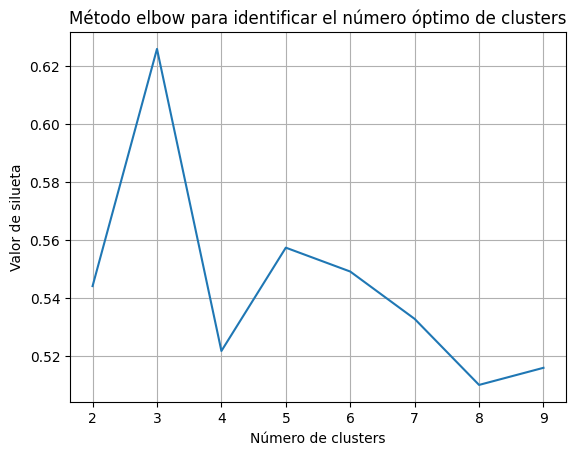

In [60]:
plt.plot(range(2,10), scoresSilhouette)
plt.xlabel('Número de clusters')
plt.ylabel('Valor de silueta')
plt.title('Método elbow para identificar el número óptimo de clusters')
plt.grid()
plt.show()

In [67]:
#número óptimo de clusters = 5
kmeansConstructor.setK(5)
kmeansModel = kmeansConstructor.fit(df)
df = kmeansModel.transform(df)
df.show(5)
scoreSilhouette = clusteringEvaluator.evaluate(df)
print(f'La silueta para 5 clusters es: {scoreSilhouette:f}')

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------------+-------------+--------------------+-----------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|ocean_proximity_encoded|     features|     scaled_features|predicted_cluster|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------------+-------------+--------------------+-----------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|          (4,[3],[1.0])| [41.0,880.0]|[3.25770230160830...|                0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|   

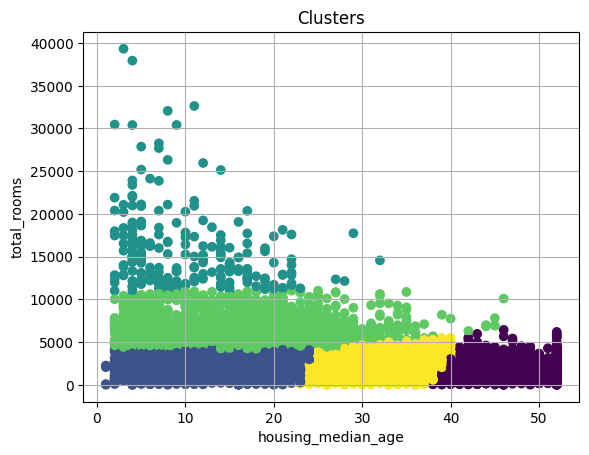

In [68]:
#para representar los cluster en un gráfico de dos dismensiones, se eligen dos características para representar en los ejes: housing_median_age y total_rooms
pdf = df.toPandas()
plt.scatter(pdf['housing_median_age'], pdf['total_rooms'], c = pdf['predicted_cluster'])
plt.xlabel('housing_median_age')
plt.ylabel('total_rooms')
plt.title('Clusters')
plt.grid()
plt.show()
